In [64]:
import pandas as pd
import numpy as np

#For the anopheline data
# roughly a box around Africa
LAT_START = -34
LAT_END = 25
LONG_START = -19
LONG_END = 53


vector_data = pd.read_csv("Anopheline_Data.csv")
vector_data = vector_data[["latitude", "longitude", "year_start", "year_end", "month_start", "month_end"]]

# stick roughly to africa
vector_data = vector_data[(vector_data["longitude"] > LONG_START)
                          & (vector_data["longitude"] < LONG_END)]
vector_data = vector_data[(vector_data["latitude"] > LAT_START)
                          & (vector_data["latitude"] < LAT_END)]

vector_data = vector_data.dropna()

# create new DataFrame and take care of year splits
vector_df = pd.DataFrame(columns=["latitude", "longitude", "year", "month"])
num_rows = vector_data.shape[0]
rowctr = 0
for row in range(num_rows):
    #used only for the first year
    mid_of_year = True
    for year in range(int(vector_data.iloc[row]["year_start"]), int(vector_data.iloc[row]["year_end"]) + 1):
        if(mid_of_year):
            start = vector_data.iloc[row]["month_start"]
            mid_of_year = False
        else:
            start = 1
        if(year == int(vector_data.iloc[row]["year_end"])):
            end = vector_data.iloc[row]["month_end"]
        else:
            end = 12
        for month in range(int(start), int(end)+1):
            vector_df.loc[rowctr] = [vector_data.iloc[row]
                                     ["latitude"], vector_data.iloc[row]["longitude"], year, month]
        rowctr += 1
vector_df.year = vector_df.year.astype(np.int64)
vector_df.month = vector_df.month.astype(np.int64)
vector_df.sort_values(by=['year', 'month'], inplace=True)

In [5]:
#For the prevalence rate data
pr_data = pd.read_csv("public_pf_data.csv")
pr_data = pr_data[["latitude", "longitude", "year_start", "year_end", "pf_pos", "pf_pr", "examined",
                                 "month_start", "month_end"]]

# stick roughly to africa
pr_data = pr_data[(pr_data["longitude"] > LONG_START)
                          & (pr_data["longitude"] < LONG_END)]
pr_data = pr_data[(pr_data["latitude"] > LAT_START)
                          & (pr_data["latitude"] < LAT_END)]

#drop null values
pr_data = pr_data.dropna()


# create new DataFrame and take care of year splits
pf_df = pd.DataFrame(columns=["latitude", "longitude", "year","pf_pos", "pf_pr", "examined", "month"])
pf_num_rows = pr_data.shape[0]
pf_rowctr = 0
for row in range(num_rows):
    #used only for the first year
    mid_of_year = True
    for year in range(int(pr_data.iloc[row]["year_start"]), int(pr_data.iloc[row]["year_end"]) + 1):
        row_data = pr_data.iloc[row]
        if(mid_of_year):
            start = row_data["month_start"]
            mid_of_year = False
        else:
            start = 1
        if(year == int(row_data["year_end"])):
            end = row_data["month_end"]
        else:
            end = 12
        for month in range(int(start), int(end)+1):
            pf_df.loc[pf_rowctr] = [row_data["latitude"], row_data["longitude"], year, row_data["pf_pos"], 
                                                 row_data["pf_pr"], row_data["examined"], month]
        pf_rowctr += 1
pf_df.year = pf_df.year.astype(np.int64)
pf_df.month = vector_df.month.astype(np.int64)
pf_df.sort_values(by=['year', 'month'], inplace=True)

/Users/panda/Desktop/python_envs/foundations_ds_env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (8,23,28,29,31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
#merge the vector data and prevalence rate data

from math import radians, cos, sin, asin, sqrt
from functools import partial

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6367 * c
    return km

def apply_haversine(row, existing_row):
    return haversine(row["longitude"], row["latitude"], existing_row["longitude"], existing_row["latitude"])

#the max distance around a prevalence rate point at which vector data can be considered
THRESHOLD = 75

vector_rows = vector_df.shape[0]
pf_rows = pf_df.shape[0]
pf_df['neighbor_vectors'] = 0.0

print("Total Rows: " + str(pf_rows))

for row in range(pf_rows):
    if row % 100 == 0:
        print(row)
    count = (vector_df.loc[(vector_df.apply(partial(apply_haversine, existing_row=pf_df.iloc[row]), axis=1) <= THRESHOLD) & 
                                          (vector_df['year']==int(pf_df.iloc[row]['year'])) &
                                          (vector_df['month']==int(pf_df.iloc[row]['month']))]).shape[0]
    pf_df.iloc[row, 7] = count

#only take those rows which have neighbor vectors
combined_df = pf_df[pf_df["neighbor_vectors"] > 0.0]

Total Rows: 8341
0


KeyboardInterrupt: 

In [ ]:
#Limit the range of years to years we have more filled out data for
combined_df = combined_df[(combined_df["year"] >= 1985) & (combined_df["year"] <= 2006)]

In [ ]:
combined_df.to_csv('combined75.csv')

In [7]:
# The merging takes a long time to run, we recommend just loading our processed data instead
df = pd.read_csv('combined75.csv')

In [8]:
# Take mean for prevalence rate
import numpy as np
# Take sum for examined and neighbor vectors
df_pr = df[['year', 'month', 'examined', 'neighbor_vectors']].groupby(['year', 'month'], as_index=False).sum()
df_pr['pf_pr'] = df[['year', 'month','pf_pr']].groupby(['year', 'month'], as_index=False).mean()['pf_pr']
#fill in 3 or more missing (year, month) with mean, otherwise impute using interpolate function

#this finds out all 3+ missing (year, month) pairs
mean = df_pr[df_pr["month"] == month]["pf_pr"].mean()
prev = None
empty_set = set()
for year in range(1985, 2007):
    for month in range(1,13):
        if df_pr[(df_pr["year"] == year) & (df_pr["month"] == month)].empty:
            if prev is None:
                prev= [(year, month)]
            else:
                prev.append((year, month))
        else:
            if prev is not None and len(prev)>2:
                empty_set.update(prev)
            prev = None

#aggregate values for each year
for year in range(1985, 2007):
    for month in range(1,13):
        if df_pr[(df_pr["year"] == year) & (df_pr["month"] == month)].empty:
            if (year, month) in empty_set:
                pr = mean
            else:   
                pr = np.nan
            examined = df_pr[df_pr["month"] == month]["examined"].mean()
            vectors = df_pr[df_pr["month"] == month]["neighbor_vectors"].mean()          
            df_pr = df_pr.append({"year": year, "month": month, "pf_pr": pr, "examined": examined, "neighbor_vectors": vectors}, ignore_index=True)

imputed_df = df_pr.sort_values(by=["year", "month"])
imputed_df['datetime'] = pd.to_datetime(imputed_df.year.astype(int).astype(str)+imputed_df.month.astype(
                                        int).astype(str), format='%Y%m')
imputed_df.set_index('datetime', inplace=True)

#impute missing values
imputed_df['pf_pr']=imputed_df['pf_pr'].interpolate(method = 'time')
imputed_df = imputed_df[1:]
imputed_df.index.name=None

In [9]:
#Second model
#use original data without merging with vector data

pf_df = pf_df[['year', 'month', 'pf_pr']].groupby(['year', 'month'], as_index=False).mean()
pf_df = pf_df.loc[(pf_df.year>=1985) & (pf_df.year<2007)]
pf_df['datetime'] = pd.to_datetime(pf_df.year.astype(int).astype(str)+pf_df.month.astype(
                                        int).astype(str), format='%Y%m')
pf_df.set_index('datetime', inplace=True)

pf_df.index.name=None

In [10]:
import statsmodels.api as sm  
import statsmodels
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

imputed_df.pf_pr.plot(figsize=(12,8), title= 'Prevalence Rate with neighbor vectors', fontsize=14, label='combined')
pf_df.pf_pr.plot(figsize=(12,8), title= 'Prevalence Rate', fontsize=14, label='original')
plt.legend()

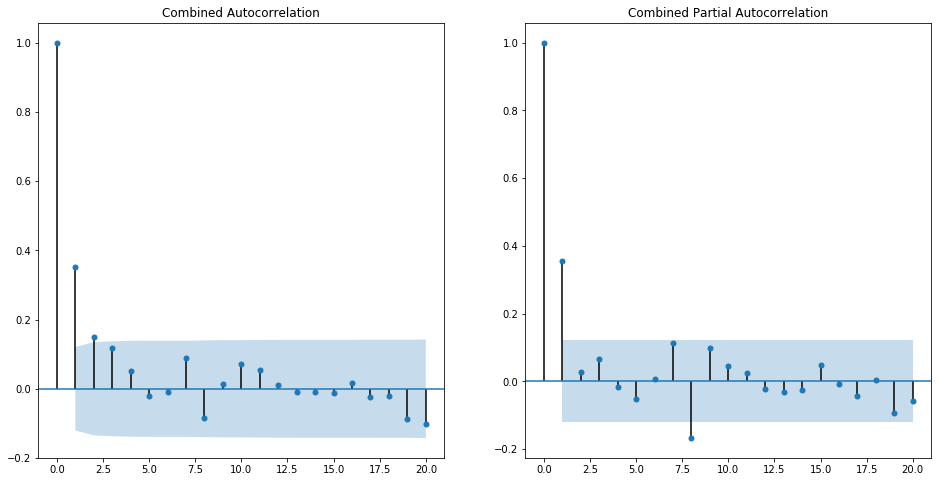

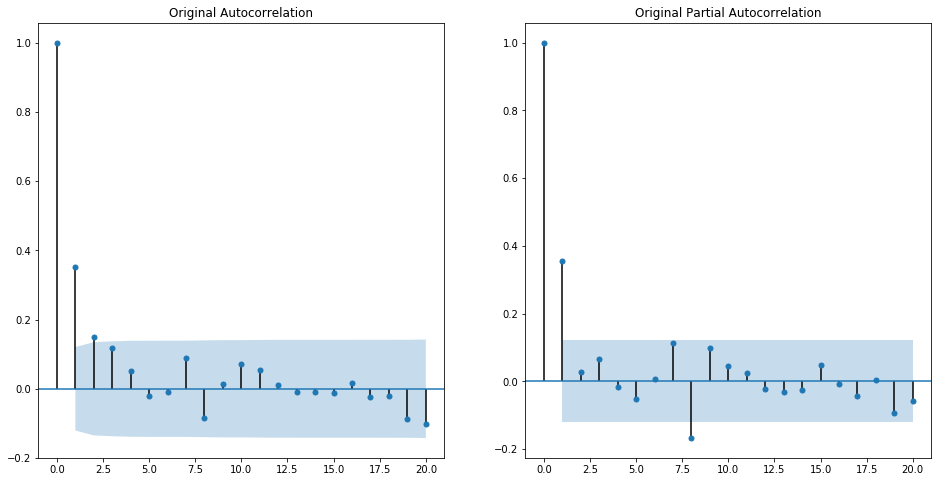

In [11]:
fig = figure(figsize=(16,8))
axis1 = fig.add_subplot(121)
fig = sm.graphics.tsa.plot_acf(imputed_df['pf_pr'], ax=axis1, lags=20, 
                               title = 'Combined Autocorrelation')
axis2 = fig.add_subplot(122)
fig = sm.graphics.tsa.plot_pacf(imputed_df['pf_pr'], ax=axis2, lags=20, 
                                title = 'Combined Partial Autocorrelation')


fig = figure(figsize=(16,8))
axis1 = fig.add_subplot(121)
fig = sm.graphics.tsa.plot_acf(imputed_df['pf_pr'], ax=axis1, lags=20,
                                title = 'Original Autocorrelation')
axis2 = fig.add_subplot(122)
fig = sm.graphics.tsa.plot_pacf(imputed_df['pf_pr'], ax=axis2, lags=20,
                                title = 'Original Partial Autocorrelation')

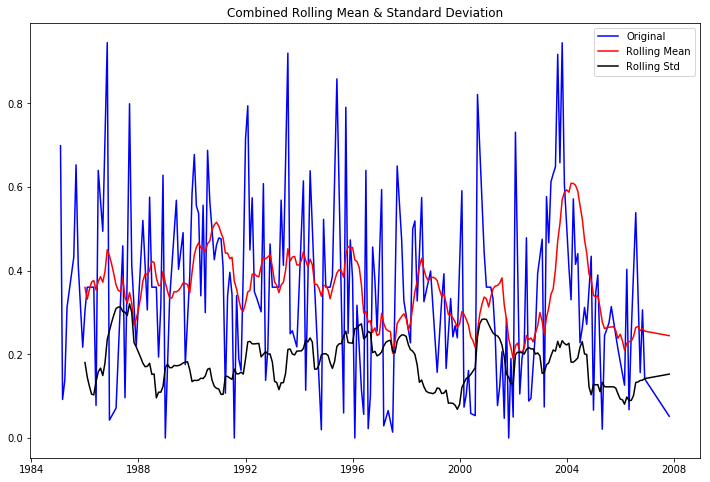

0.31148342619999814


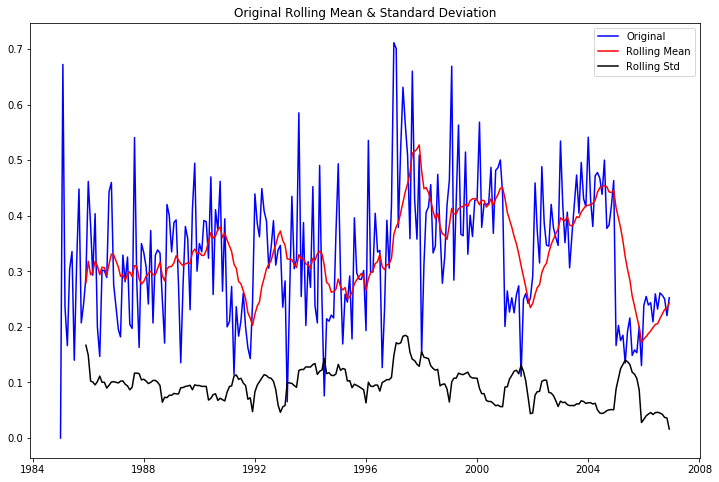

0.14293146823035


In [12]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, label):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(center=False, window=12).mean()
    rolstd = timeseries.rolling(center=False, window=12).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title(label + ' Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Durbin Watson test:
    dfoutput=sm.stats.durbin_watson(timeseries)

    print(dfoutput)

test_stationarity(imputed_df.pf_pr, 'Combined')
test_stationarity(pf_df.pf_pr, 'Original')

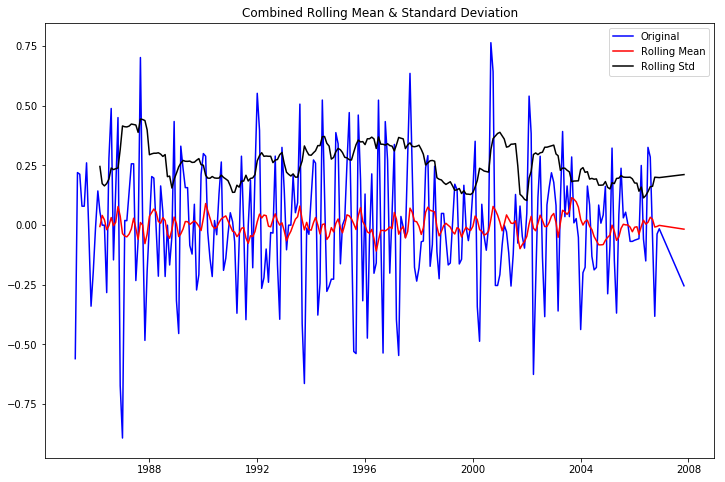

1.7059157461762904


2.0318615852619804


In [13]:
imputed_df['first_difference'] = imputed_df.pf_pr - imputed_df.pf_pr.shift(2)

test_stationarity(imputed_df.first_difference.dropna(inplace=False), 'Combined')

pf_df['first_difference'] = pf_df.pf_pr - pf_df.pf_pr.shift(2)

test_stationarity(pf_df.first_difference.dropna(inplace=False), 'Original')

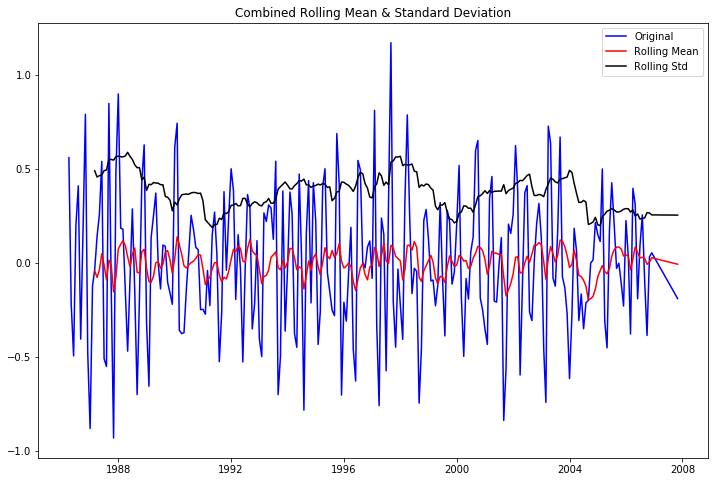

1.7495960221422278


1.9037720614133877


In [14]:
imputed_df['seasonal_first_difference'] = imputed_df.first_difference - imputed_df.first_difference.shift(12)
test_stationarity(imputed_df.seasonal_first_difference.dropna(inplace=False), 'Combined')

pf_df['seasonal_first_difference'] = pf_df.first_difference - pf_df.first_difference.shift(12)
test_stationarity(pf_df.seasonal_first_difference.dropna(inplace=False), 'Original')

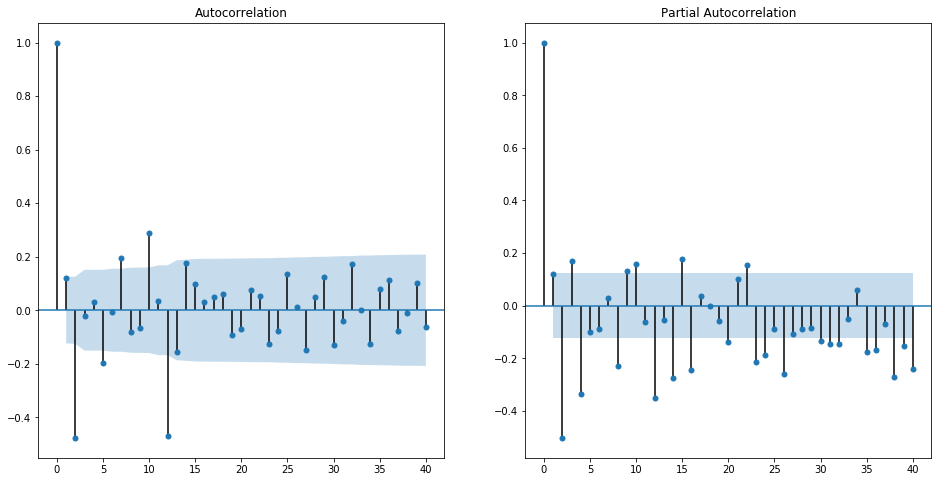

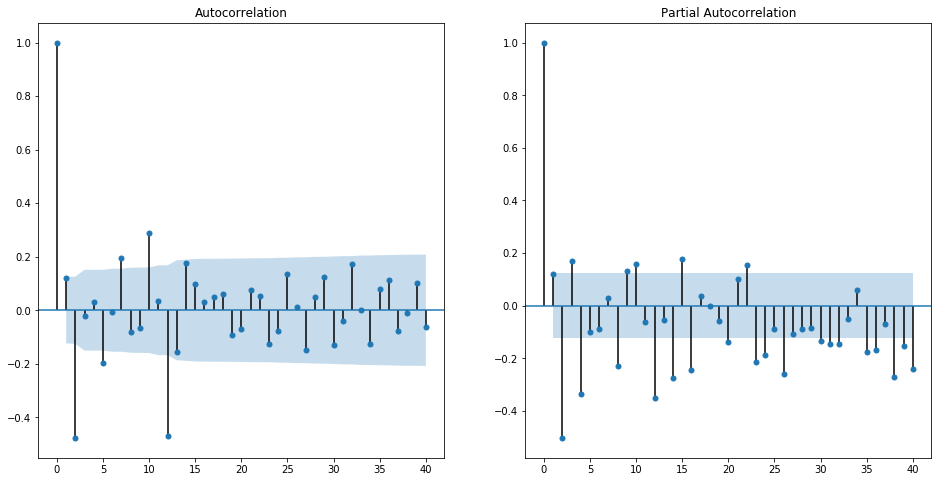

In [15]:
fig = figure(figsize=(16,8))
axis1 = fig.add_subplot(121)
fig = sm.graphics.tsa.plot_acf(imputed_df.seasonal_first_difference.iloc[14:], ax=axis1, lags=40)
axis2 = fig.add_subplot(122)
fig = sm.graphics.tsa.plot_pacf(imputed_df.seasonal_first_difference.iloc[14:], ax=axis2, lags=40)

fig = figure(figsize=(16,8))
axis1 = fig.add_subplot(121)
fig = sm.graphics.tsa.plot_acf(imputed_df.seasonal_first_difference.iloc[14:], ax=axis1, lags=40)
axis2 = fig.add_subplot(122)
fig = sm.graphics.tsa.plot_pacf(imputed_df.seasonal_first_difference.iloc[14:], ax=axis2, lags=40)

In [67]:
#split merged dataset into train and test
split = int(imputed_df.pf_pr.size * 0.8)
combined_training = imputed_df.pf_pr[1:split]
combined_test = imputed_df.pf_pr[split:]
neighbor_vector_train = imputed_df.neighbor_vectors[1:split]
neighbor_vector_test = imputed_df.neighbor_vectors[split:]

#train ARIMA for merged dataset
merged_data_model = sm.tsa.ARIMA(combined_training, (1, 0, 1)).fit()
imputed_df['forecast'] = merged_data_model.predict(start = 1)

imputed_df[['pf_pr', 'forecast']].plot(figsize=(12, 12))

#train ARIMA for merged dataset with neighbor vectors
merged_data_model_exog = sm.tsa.ARIMA(combined_training, (1, 0, 1), exog=neighbor_vector_train).fit()
imputed_df['forecast_exog'] = merged_data_model_exog.predict(start = 1, exog=neighbor_vector_train)
imputed_df[['pf_pr', 'forecast_exog']].plot(figsize=(12, 12))

#split original dataset into train and test
split = int(pf_df.pf_pr.size * 0.8)
original_training = pf_df.pf_pr[1:split]
original_test = pf_df.pf_pr[split:]

#train ARIMA for original dataset
original_data_model = sm.tsa.ARIMA(original_training, (1, 0, 1)).fit()
pf_df['forecast'] = original_data_model.predict(start = 1)
pf_df[['pf_pr', 'forecast']].plot(figsize=(12, 12))

/Users/panda/Desktop/python_envs/foundations_ds_env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/panda/Desktop/python_envs/foundations_ds_env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/panda/Desktop/python_envs/foundations_ds_env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [58]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [59]:
from sklearn.metrics import mean_absolute_error
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true) *100 )

normal test for combined dataset  NormaltestResult(statistic=3.86302835754531, pvalue=0.14492858447198778)
normal test for combined dataset with exogenous variables  NormaltestResult(statistic=4.047864940015827, pvalue=0.13213482581240515)
normal test for original dataset  NormaltestResult(statistic=8.615463363273609, pvalue=0.013464055747226138)


/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


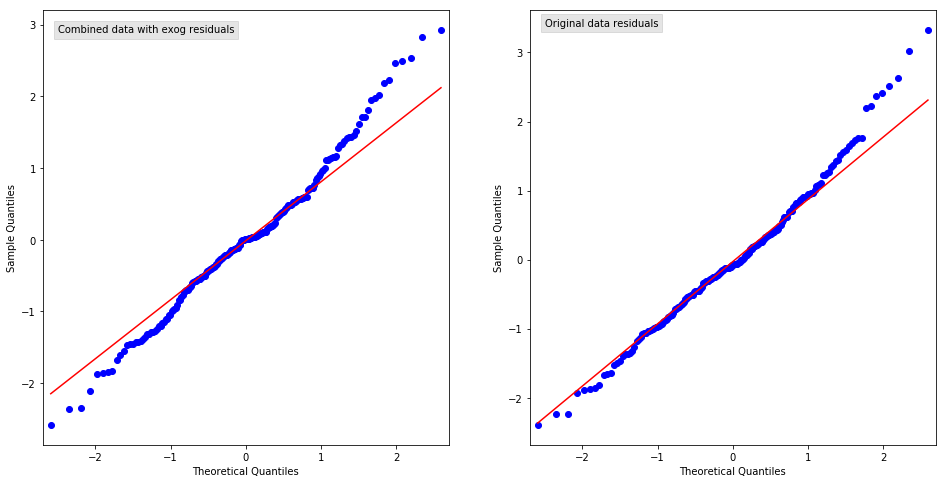

In [107]:
#find residuals and perform normaltest

from scipy import stats
from statsmodels.graphics.api import qqplot
resid = merged_data_model.resid
print('normal test for combined dataset ', stats.normaltest(resid))

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121)
txt = ax.text(-2.5, 3, "Combined data residuals",
              verticalalignment='top')
txt.set_bbox(dict(facecolor='k', alpha=0.1))
fig = qqplot(resid, line='q', ax=ax, fit=True)

resid = merged_data_model_exog.resid
print('normal test for combined dataset with exogenous variables ', stats.normaltest(resid))

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121)
txt = ax.text(-2.5, 3, "Combined data with exog residuals",
              verticalalignment='top')
txt.set_bbox(dict(facecolor='k', alpha=0.1))
fig = qqplot(resid, line='q', ax=ax, fit=True)

resid = original_data_model.resid
print('normal test for original dataset ',stats.normaltest(resid))

ax = fig.add_subplot(122)
txt = ax.text(-2.5, 3.5, "Original data residuals",
              verticalalignment='top')
txt.set_bbox(dict(facecolor='k', alpha=0.1))
fig = qqplot(resid, line='q', ax=ax, fit=True)

In [113]:
#test model on combined dataset
combined_forecast = merged_data_model.predict(start = 208, end = 260 , dynamic=True)
combined_actual   = imputed_df["pf_pr"][208:261]

#test model on combined dataset with exog variables
combined_forecast_exog = merged_data_model_exog.predict(start = 208, end = 260 , exog=neighbor_vector_test, dynamic=True)
combined_actual_exog   = imputed_df["pf_pr"][208:261]

#test model on original dataset
original_forecast = original_data_model.predict(start = 208, end = 260 , dynamic=True)
original_actual   = pf_df["pf_pr"][208:261]

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [114]:
print('mean absolute Percentage error for combined data', mean_absolute_percentage_error(combined_actual, combined_forecast))
print('mean absolute Percentage error for original data', mean_absolute_percentage_error(original_actual, original_forecast))
print('mean absolute Percentage error for combined data with exog variables',
      mean_absolute_percentage_error(combined_actual_exog, combined_forecast_exog))

mean absolute Percentage error for combined data 99.75123541037367
mean absolute Percentage error for original data 41.402979605858484
mean absolute Percentage error for combined data with exog variables 100.1664405971191


In [115]:
print(" Combined dataset MAE:", mean_absolute_error(combined_actual, combined_forecast))
print("Original dataset MAE:", mean_absolute_error(original_actual, original_forecast))
print(" Combined dataset with exog variables MAE:", mean_absolute_error(combined_actual_exog, combined_forecast_exog))

 Combined dataset MAE: 0.15780589020636487
Original dataset MAE: 0.10279434362377658
 Combined dataset with exog variables MAE: 0.1586583028866775
